# Test Battery for Clique Detection

I'm here:
1. Extact loops from the pair
1. Fix the ```1AB 2AB 3AB --> 123 AB``` problem

In [1]:
# Parameters
# METHOD_ID="2020-01-20 partial pairs"
# METHOD_ID="2020-01-24 all pairs"
METHOD_ID="2020-01-25 loop"
METHOD_ID="2020-01-28 loops removed"

In [2]:
%load_ext autoreload
%autoreload 2
# %config Application.log_level="INFO"

import math
import logging
import sys
import networkx as nx
# import scipy
import matplotlib.pyplot as plt

In [3]:
# logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO, stream=sys.stdout)

In [70]:
def find_loops_in_path(p, succ_G):
    """
    With all pairs, if ABC is a loop in pairs of len L then 
    f(A,B) = f(B,C) = L(L+1)/2 and f(B,A) = f(C,B) = L(L-1)/2
    """
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    is_a_loop, L = False, 0

    # Check if p is a loop
    for a, b in [ (a,b) for a,b in zip( p[:-1], p[1:] )  ]:

        is_a_loop = True
        setL = set()
        if is_a_loop and (b, a) in succ_G.edges() and (a, b) in succ_G.edges():
            Wab = succ_G[a][b]['weight'] # also, Wab=f by construction
            Wba = succ_G[b][a]['weight']
            
            # Combinatory test:
            """
            W1 = (L+1)*L/2.0 = (L^2 + L)/2
            W2 = L*(L-1)/2.0 = (L^2 - L)/2
            2*W1 = L^2 + L
            2*W2 = L^2 - L
            2(W1+W2) = 2 L^2
            L = sqr(W1+W2) # Integer
            """
            L = int( math.sqrt(Wab + Wba) )
            Lp1, Lm1 = (L+1)*L/2.0, L*(L-1)/2.0
            
            setL.add(L)

            logger.debug( (a, b, Wab, Lp1, Wba, Lm1, L ))
            
            # Me falta chequear que L+1 y L-1 sean consistentes en todfo el path
            if Wab != Lp1 or Wba != Lm1:
                is_a_loop = False
        else:
            is_a_loop = False     
            
    if is_a_loop and len(setL) != 1:
        is_a_loop = False

    return is_a_loop, L

In [158]:
def remove_loops_in_trace(paths_loop, succ_G):
    """
    A loop... should be disjoint with other loops?
    I believe YES
    """
    logger = logging.getLogger( sys._getframe().f_code.co_name )

    loops_found = []
    loops_candidates = []


    for f, paths_f in paths_loop.items():
        
        for p in paths_f:
            
            # Magic here
            is_a_loop, L = find_loops_in_path(p, succ_G)

            if is_a_loop:
                logger.info("Loop candidate FOUND: repeated %d times in this trace, loop: %s" % (L, p) )
                loops_candidates.append( (L,p) )
                
    # Check Loop Disjoints
    if len(loops_candidates) == 1:
        loops_found = loops_candidates
        logger.info("My dude %s is a real %s-loop" % (loops_found[0][1], loops_found[0][0]))
    else:
        for L, path in loops_candidates:
            # If path is disjoint with someone else, append both
            for L2, p2 in loops_candidates: # [(L2, p2) for L2, p2 in loops_candidates if p2 != path]:
                if path != p2:
                    # p2 and path are disjoints!
                    # path must be also disjoint with all foud loops
                    if not set(p2).intersection( set(path) ) and \
                    all( [ not set(p_found).intersection( set(path) ) for Lx, p_found in loops_found] ):
                        logger.info("My dude %s is a real %s-loop" % (path, L))
                        loops_found.append((L, path))

                
    for L, p in loops_found:

        # Then remove the back edges from succ_G
        # I already stated that the loop is A...Z, then I will remove Z...A
        for i_u in range(0, len(p)):
            for i_v in range(i_u, len(p)):
                logger.debug("Removing %s, %s" % (p[i_v], p[i_u]))
                try:
                    succ_G.remove_edge(p[i_v], p[i_u])
                except:
                    logger.debug("Hohoho! that pair was already removed")
        logger.debug("Removed %s" % list(reversed(p)))
                
    return loops_found, succ_G

In [134]:
def evaluate_against (T, expected_paths):
    logger = logging.getLogger( sys._getframe().f_code.co_name )

    G, paths = False, False
    
    if   METHOD_ID=="2020-01-24 all pairs":
        paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T, METHOD_ID="2020-01-24 all pairs")  ) ) )

        
    elif METHOD_ID=="2020-01-20 partial pairs":
        paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T, METHOD_ID="2020-01-20 partial pairs")  ) ) )

        
    elif METHOD_ID=="2020-01-25 loop":
        
        all_successors_combined = False
        # Remove the loops in each trace, and
        
        for trace in T[0:1]:

            # Calculate the successors only for this trace
            succ_f = get_successor_by_freq([trace], METHOD_ID=METHOD_ID)
            # Put in a graph
            succ_G = successorsGraph( succ_f )

            # Detect loops first computing raw paths
            paths_loop = infer_paths( split_in_freqGraph(  succ_G  ) )
            
            loops_found, succ_G_acyclic = remove_loops_in_trace(paths_loop, succ_G)
            
            # Claim: the graph should be cycle free. So, let's remove any trivial cycle AB BA not in loops!
            succ_G_acyclic_forReal = nx.DiGraph()
            E = succ_G_acyclic.edges()
            for u, v in E:
                if (v, u) not in E:
                    succ_G_acyclic_forReal.add_edge(u, v, weight=succ_G_acyclic[u][v]["weight"]  )

            # Get paths with the acyclic graph       
            paths = infer_paths( split_in_freqGraph(  succ_G_acyclic_forReal  ) )

            # Untangle the graph: If paths (u,z,v) and (u,v) exists, leave just (u,z,v)
            G = path_graph( paths )
            G = minimally_connected(G)
            graph(G)

# This was the old untangled
        
#         G_aux = created_auxiliary_graph( paths )
#         G = minimally_connected(G_aux)
        
#         G_freq = split_in_freqGraph(G)
#         for f, g1 in G_freq.items():
#             graph(g1, with_weigths=True)
            
#         graph(G)

#         paths = { 1:[] }
# #         for f, G1 in G_freq.items():
# #             paths[f] = nx.all_shortest_paths(G, "_START_", "_END_")
            
#         for path in nx.all_simple_paths(G, "_START_", "_END_"):
#             path.remove("_START_")
#             path.remove("_END_")
#             paths[1].append( path )
        

    else:
        raise ValueError("Not valid METHOD_ID")
             
            
    if paths:
        
#         G = nx.DiGraph()
#         for f, path in paths.items():
#             for a, b in [ (a,b) for t in path for a,b in zip( t[:-1], t[1:] )  ]:
#                 G.add_edge( a, b, weight=f)
#         graph(G, with_weigths=True )
        
        good = []
        bad = []
        expected = [ list(a) for a in expected_paths ]
        for f, paths in paths.items():
            for p in paths:
    #             print(paths)
                if p in expected:
                    good.append( "%d: %s" % (f, "".join(p)) )
                else:
                    bad.append( "%d: %s" % (f, "".join(p)) )

        if len(expected_paths) != len(good):
            print(), print()
            print("WARNING HERE! OJO AQUI!")
            print(), print()
        print("These %s paths were correctly detected (%s undetected):" % (len(good), len(expected_paths)-len(good)))
        print(good)
        print()

        print("These %s paths are spurious:" % len(bad))
        print (bad)
        return good, bad
    else:
        return [], []

In [121]:
def path_graph( weighted_paths ):
    
    def append_path(G, path, weight):
        edges = []
        previous = path[0]
        for node in path[1:]:
            edges.append( (previous, node, {"weight": round(weight, 2)} ) )
            previous = node
        G.add_edges_from(edges)

    G = nx.DiGraph()
    for w in sorted(weighted_paths, reverse=True):
        for path_w in weighted_paths[w]:
            append_path( G, path_w, w )            
    return G

In [47]:
#2020-01-25
# If paths (u,z,v) and (u,v) exists, leave just (u,z,v)
def minimally_connected(G):
    G_minimal = G.copy()
    
    for u, v in G.edges():

        # u has already v, then I will work if I have more than one neighbor
        if len(G[u]) > 1:
            remove_edge = False
            # look if I have a longest u,z,v path
            for z, attr in G[u].items():
                if z != v and z != u:
                    if nx.has_path(G_minimal, z, v):
                        remove_edge = True
            if remove_edge:
                G_minimal.remove_edge( u, v )    
    return G_minimal

In [8]:
def graph(G, color="#cccccc", with_weigths=True):
    pos = nx.circular_layout(G)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.subplot(111)

    nx.draw_networkx (G, pos, width=1, node_color=color, with_labels=True, connectionstyle='arc3, rad=0.03' )
    if with_weigths:
        weights = { (str(u), str(v)): G[u][v]['weight'] for u,v in G.edges() }
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights)
    plt.show()

In [9]:
def get_successor_by_freq( traces, METHOD_ID="2020-01-24 all pairs" ):
    """
    Get successor pairs in every T in traces, and combine them by frequency of appearance.
    
    >>> T = [ list("ABC"), list("ABCABC") ]
    >>> get_successor_pairs_by_freq(T)
    {('A', 'B'): 3, ('A', 'C'): 3, ('B', 'C'): 3, ('B', 'A'): 1, ('C', 'A'): 1, ('C', 'B'): 1}
    """
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    logger.info("Using METHOD_ID % s" % METHOD_ID)
    
    pairs_with_freq = {}
    L = float(len(traces))

    for trace in traces:
        for pair in get_successor_pairs(trace, METHOD_ID=METHOD_ID):
            if pair in pairs_with_freq.keys():
                pairs_with_freq[pair] = pairs_with_freq[pair] + 1.0/L
            else:
                pairs_with_freq[pair] = 1.0/L
            
    By_freq = {}
    for (u, v), freq in pairs_with_freq.items():
        f = round(freq,3)
        if f in By_freq.keys():
            By_freq[f].append( (u,v) )
        else:
            By_freq[f] =[ (u,v) ]
    logger.debug("Freq  pairs using method=%s : %s" % (METHOD_ID, By_freq) )
    return By_freq

In [10]:
def successorsGraph(successor_by_freq):
    G=nx.DiGraph()
    for f, pairs in successor_by_freq.items():
        for u, v in pairs:
            G.add_edge(u, v, weight=f)
            
    return G

In [11]:
# Sort the cliques and apply the rules:
# 1) The nodes of a single path in their equivalent pair has in_degree=0,1,2,...
# 2) A path is composed for at least 2 nodes

def infer_paths(G_freq, min_clique_size=2):
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    logger.debug("Received a dict G with f=%s" % G_freq.keys())

    paths_f = {}
    cliques_f = { f: list(nx.algorithms.clique.find_cliques( G_freq[f].to_undirected() )) for f in G_freq.keys() }
    logger.debug("All cliques are %s" % cliques_f)
        
    for f, cliques in cliques_f.items():
#         logger.debug("Clique[%d] = %s" % (f, cliques) )
        paths = []
        for clique in cliques:
            logger.debug("F=%d, clique=%s" % (f, clique))
    
            # From the original graph(f),
            G_complete = G_freq[f].copy()
            
            # remove the nodes not in this clique 
            for node in set(G_complete.nodes).difference( set(clique) ):
                G_complete.remove_node(node)
                
            # Order nodes by inner degree
            nodes = sorted( G_complete.in_degree() , key=lambda p: p[1], reverse=False)
            logger.debug("Nodes: %s" %  nodes)

            # - core - CRITERIA 1 and 2
            # Strict checking: in_degree(n) in [0, ... , len(N)-1]
            if len(nodes) >=min_clique_size and ( 
                all( [in_degree == i for i, (a, in_degree) in zip(range(0, len(nodes)), nodes)] ) 
                or
                all( [in_degree == i+1 for i, (a, in_degree) in zip(range(0, len(nodes)), nodes)] ) 
            ):
                    paths.append ( [ a for a, in_degree in nodes ] )
            else:
                logger.debug("This clique doesn't match the in_degree critera")
        if paths:
            paths_f[f] = paths

    logger.info("Paths inferred (min_clique_size=%d: %s)" % (min_clique_size, paths_f) )
    return paths_f

In [12]:
# Including Modifications by Andres (20200124)
ADD_START_END = False
def get_successor_pairs( T_prime , ADD_START_END=ADD_START_END, METHOD_ID="2020-01-24 all pairs"):
    """
    Get near successor pairs
    
    Given the trace $T' = s_1 ... s_L$
    For every $1 <= i <= L$ find the maximal subtrace starting at $i$
    $T_i_j = s_i ... s_j$ such that $s_i \ne s_k$ for all $i < k <= j$
    
    Return the concatenation for all $T_i_j$
    [ (s_i, s_k) ] for all s_i \in T_i_j, s_k \in T_i_j for all i < k <= j
    
    ADDED 2020-01-23:
    Que no se repitan!

    
    >>> get_successor_pairs(list("ABCD"))
    [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
    """

    logger = logging.getLogger( sys._getframe().f_code.co_name )
    logger.info("Using METHOD_ID % s" % METHOD_ID)


    pairs = []
    for i in range(0, len(T_prime)-1):


        partial_subtrace = T_prime[i:]

        s_i = partial_subtrace.pop(0)
        L = len(partial_subtrace)

        # Find first first j such s_i == s_j, or L if not exists
        if s_i in partial_subtrace:
            j = partial_subtrace.index(s_i)
        else:
            j = L

        # This is the subtrace T_i_j, the maximal that not contains s1
        # (Actually, it not contains s_i)
        if METHOD_ID == "2020-01-20 partial pairs":
#         if METHOD_ID != "2020-01-24 all pairs":
            T_i_j=partial_subtrace[:j] # 2020-01-20 Old BEHAVIOR
        else:
            T_i_j=partial_subtrace[:] # Andres 20200124 .. all friends with all, including loops
        
        T_i_j_pairs = [] # 2020-01-23 BEHAVIOR ... but not remove, it doesn't affect

        # Construct all s_i, s_k , i < k <= j
        for s_k in T_i_j:
            e = (s_i, s_k)

            pairs.append(e)       # 2020-01-20 Old BEHAVIOR
            
#             if e not in T_i_j_pairs:  # 2020-01-23 BEHAVIOR
#                 T_i_j_pairs.append(e) # 2020-01-23 BEHAVIOR
#         pairs += T_i_j_pairs          # 2020-01-23 BEHAVIOR
            
            
            # Added 2020-01-18: global star / end
            if ADD_START_END:
                pairs.append( ("_START_", s_i) )
                pairs.append(( s_k, "_END_") )

    logger.debug("Found pairs using method=%s : %s" % (METHOD_ID, pairs) )
    return pairs

In [13]:
def split_in_freqGraph( successorsGraph ):
    
    logger = logging.getLogger( sys._getframe().f_code.co_name )
    u_v_f = [ (u, v, successorsGraph[u][v]["weight"]) for u, v in successorsGraph.edges]
    frqs = set([ f for u, v, f in u_v_f])
    logger.debug("freqs found: %s" % frqs)
    G={}
    for f in frqs:
        G[f] = successorsGraph.copy()
        # Get all nodes whose pairs has weight!=f
        for u, v, f2 in u_v_f:
            if f != f2:
                G[f].remove_edge(u,v)
        logger.debug("Nodes in freq=%d: %s" % (f, G[f].nodes) )
        
    logger.debug("About to return a set of G with f=%s" % G.keys())
    return G

## Tested examples

### Simple Loop Examples

INFO:Using METHOD_ID 2020-01-25 loop
INFO:Using METHOD_ID 2020-01-25 loop
INFO:Paths inferred (min_clique_size=2: {10.0: [['A', 'B', 'C']], 6.0: [['C', 'B', 'A']]})
INFO:My dude ['A', 'B', 'C'] is a real 4-loop
INFO:Paths inferred (min_clique_size=2: {10.0: [['A', 'B', 'C']]})


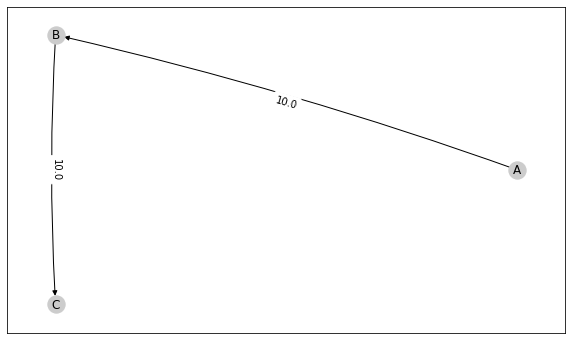

These 1 paths were correctly detected (0 undetected):
['10: ABC']

These 0 paths are spurious:
[]


In [144]:
T = [
    list("ABCABCABCABC"),
]
g, b = evaluate_against(T, ["ABC"] )

INFO:Using METHOD_ID 2020-01-25 loop
INFO:Using METHOD_ID 2020-01-25 loop
INFO:Paths inferred (min_clique_size=2: {1.0: [['D', 'C', 'B', 'A']], 3.0: [['A', 'B', 'C', 'D']]})
INFO:My dude ['A', 'B', 'C', 'D'] is a real 2-loop
INFO:Paths inferred (min_clique_size=2: {3.0: [['A', 'B', 'C', 'D']]})


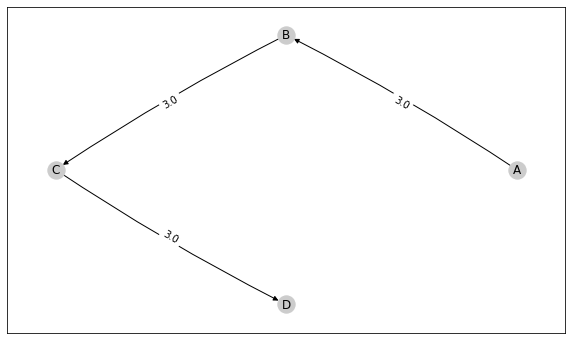

These 1 paths were correctly detected (0 undetected):
['3: ABCD']

These 0 paths are spurious:
[]


In [145]:
T = [
    list("ABCDABCD"),
]
g, b = evaluate_against(T, ["ABCD"] )

INFO:Using METHOD_ID 2020-01-25 loop
INFO:Using METHOD_ID 2020-01-25 loop
INFO:Paths inferred (min_clique_size=2: {1.0: [['D', 'C', 'B', 'A'], ['1', '2', '3', '4', 'x', 'y', 'z']], 2.0: [['4', 'C'], ['2', 'C'], ['3', 'C'], ['C', 'y'], ['C', 'x'], ['1', 'C'], ['C', 'z'], ['4', 'D'], ['2', 'D'], ['3', 'D'], ['D', 'y'], ['D', 'x'], ['1', 'D'], ['D', 'z'], ['4', 'A'], ['2', 'A'], ['3', 'A'], ['A', 'y'], ['A', 'x'], ['1', 'A'], ['A', 'z'], ['4', 'B'], ['2', 'B'], ['3', 'B'], ['B', 'y'], ['B', 'x'], ['1', 'B'], ['B', 'z']], 3.0: [['A', 'B', 'C', 'D']]})
INFO:My dude ['A', 'B', 'C', 'D'] is a real 2-loop
INFO:Paths inferred (min_clique_size=2: {1.0: [['1', '2', '3', '4', 'x', 'y', 'z']], 2.0: [['4', 'C'], ['2', 'C'], ['3', 'C'], ['C', 'y'], ['C', 'x'], ['1', 'C'], ['C', 'z'], ['4', 'D'], ['2', 'D'], ['3', 'D'], ['D', 'y'], ['D', 'x'], ['1', 'D'], ['D', 'z'], ['4', 'A'], ['2', 'A'], ['3', 'A'], ['A', 'y'], ['A', 'x'], ['1', 'A'], ['A', 'z'], ['4', 'B'], ['2', 'B'], ['3', 'B'], ['B', 'y'], ['B'

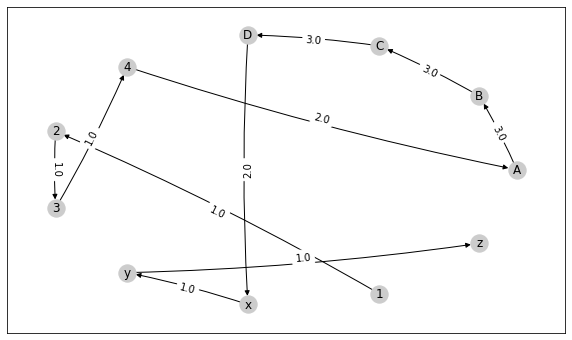

These 2 paths were correctly detected (0 undetected):
['1: 1234xyz', '3: ABCD']

These 28 paths are spurious:
['2: 4C', '2: 2C', '2: 3C', '2: Cy', '2: Cx', '2: 1C', '2: Cz', '2: 4D', '2: 2D', '2: 3D', '2: Dy', '2: Dx', '2: 1D', '2: Dz', '2: 4A', '2: 2A', '2: 3A', '2: Ay', '2: Ax', '2: 1A', '2: Az', '2: 4B', '2: 2B', '2: 3B', '2: By', '2: Bx', '2: 1B', '2: Bz']


In [146]:
T = [
    list("1234ABCDABCDxyz"),
]
g, b = evaluate_against(T, ["ABCD", "1234xyz"] )

INFO:Using METHOD_ID 2020-01-25 loop
INFO:Using METHOD_ID 2020-01-25 loop
INFO:Paths inferred (min_clique_size=2: {1.0: [['z', 'x', 'c', 'v']], 4.0: [['C', '1'], ['3', 'C'], ['2', 'C'], ['A', '1'], ['B', '1'], ['2', 'B']], 5.0: [['1', 'C'], ['C', '3'], ['C', '2'], ['1', 'A'], ['1', 'B'], ['B', '2']], 6.0: [['A', 'B', 'C'], ['1', '2', '3'], ['A', '2', '3'], ['A', 'B', '3']]})
INFO:My dude ['A', 'B', 'C'] is a real 3-loop
INFO:My dude ['1', '2', '3'] is a real 3-loop
INFO:Paths inferred (min_clique_size=2: {1.0: [['z', 'x', 'c', 'v']], 3.0: [['C', 'x'], ['2', 'x'], ['3', 'x'], ['1', 'x'], ['A', 'x'], ['B', 'x'], ['C', 'c'], ['2', 'c'], ['3', 'c'], ['1', 'c'], ['A', 'c'], ['B', 'c'], ['C', 'v'], ['2', 'v'], ['3', 'v'], ['1', 'v'], ['A', 'v'], ['B', 'v'], ['C', 'z'], ['2', 'z'], ['3', 'z'], ['1', 'z'], ['A', 'z'], ['B', 'z']], 6.0: [['A', 'B', 'C'], ['1', '2', '3']]})


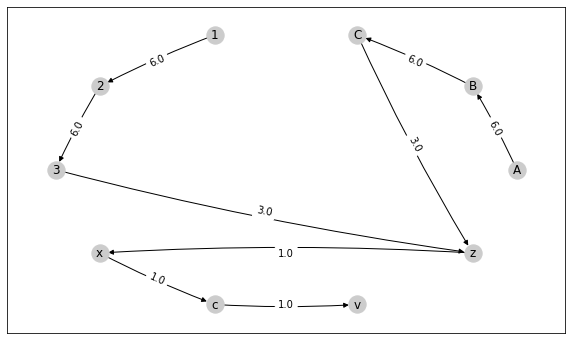

These 3 paths were correctly detected (0 undetected):
['1: zxcv', '6: ABC', '6: 123']

These 24 paths are spurious:
['3: Cx', '3: 2x', '3: 3x', '3: 1x', '3: Ax', '3: Bx', '3: Cc', '3: 2c', '3: 3c', '3: 1c', '3: Ac', '3: Bc', '3: Cv', '3: 2v', '3: 3v', '3: 1v', '3: Av', '3: Bv', '3: Cz', '3: 2z', '3: 3z', '3: 1z', '3: Az', '3: Bz']


In [147]:
# Type 75
T = [
    list("ABC1231A2B3C1ABC23zxcv"),
]
g, b = evaluate_against(T, ("ABC", "123", "zxcv") )

In [ ]:
T = [
    list("ABCDABCD"),
    list("1234512345"),
    list("12345")
]
g, b = evaluate_against(T, ["ABCD", "12345"] )

### Complex Loop Examples

INFO:Using METHOD_ID 2020-01-25 loop
INFO:Using METHOD_ID 2020-01-25 loop
INFO:Paths inferred (min_clique_size=2: {1.0: [['3', '2', '1']], 3.0: [['C', 'B', 'A'], ['1', '2', '3']], 6.0: [['1', 'A', 'B', 'C'], ['3', 'A', 'B', 'C'], ['2', 'A', 'B', 'C']]})
INFO:Loop candidate FOUND: repeated 2 times in this trace, loop: ['1', '2', '3']
INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['1', 'A', 'B', 'C']
INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['3', 'A', 'B', 'C']
INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['2', 'A', 'B', 'C']
INFO:Paths inferred (min_clique_size=2: {6.0: [['1', 'C'], ['3', 'C'], ['2', 'C'], ['1', 'A'], ['3', 'A'], ['2', 'A'], ['1', 'B'], ['3', 'B'], ['2', 'B']]})


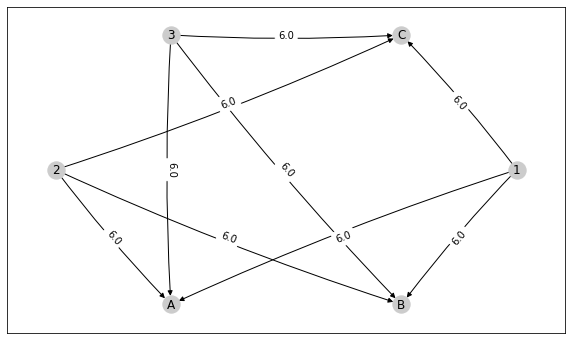



WARNING HERE! OJO AQUI!


These 0 paths were correctly detected (2 undetected):
[]

These 9 paths are spurious:
['6: 1C', '6: 3C', '6: 2C', '6: 1A', '6: 3A', '6: 2A', '6: 1B', '6: 3B', '6: 2B']


In [161]:
# Type 76
T = [
    list("123123ABCABCABC")
]
g, b = evaluate_against(T, ("ABC", "123") )

In [ ]:
# Type 76-b
T = [
    list("ABCABCABC"),
    list("123123123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

INFO:Using METHOD_ID 2020-01-25 loop
INFO:Using METHOD_ID 2020-01-25 loop
INFO:Paths inferred (min_clique_size=2: {1.0: [['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']], 2.0: [['g', 'C'], ['m', 'C'], ['k', 'C'], ['f', 'C'], ['h', 'C'], ['l', 'C'], ['C', 's'], ['C', 'r'], ['p', 'C'], ['C', 't'], ['i', 'C'], ['j', 'C'], ['o', 'C'], ['e', 'C'], ['q', 'C'], ['n', 'C'], ['C', 'u'], ['2', 'r'], ['2', 'o'], ['2', 'n'], ['2', 'p'], ['f', '2'], ['2', 'u'], ['g', '2'], ['2', 'm'], ['c', '2'], ['j', '2'], ['2', 'q'], ['d', '2'], ['2', 'l'], ['h', '2'], ['k', '2'], ['2', 's'], ['2', 't'], ['i', '2'], ['e', '2'], ['b', 'A'], ['3', 'r'], ['o', '3'], ['n', '3'], ['p', '3'], ['3', 'y'], ['f', '3'], ['3', 'x'], ['3', 'u'], ['g', '3'], ['m', '3'], ['j', '3'], ['3', 'q'], ['3', 'w'], ['3', 'v'], ['k', '3'], ['h', '3'], ['l', '3'], ['3', 's'], ['3', 't'], ['i', '3'], ['e', '3'], ['d', '1'], ['d', 'A'], ['d', 'B'], ['g', '1

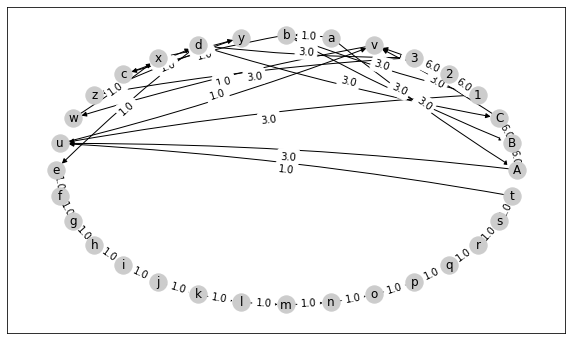

These 3 paths were correctly detected (0 undetected):
['1: abcdefghijklmnopqrstuvwxyz', '6: ABC', '6: 123']

These 43 paths are spurious:
['3: Cv', '3: aC', '3: bC', '3: Cy', '3: dC', '3: Cx', '3: cC', '3: Cz', '3: Cw', '3: 2v', '3: a2', '3: b2', '3: 2y', '3: 2x', '3: 2z', '3: 2w', '3: Av', '3: aA', '3: Ay', '3: Ax', '3: Au', '3: Az', '3: Aw', '3: 1u', '3: 1v', '3: a1', '3: b1', '3: 1y', '3: 1x', '3: 1z', '3: 1w', '3: Bv', '3: aB', '3: bB', '3: By', '3: Bx', '3: Bz', '3: Bw', '3: b3', '3: a3', '3: d3', '3: c3', '3: 3z']


In [162]:
# Type 77
T = [
    list("aAb1B2cd3Cefgh1iAjk2Blmnop3qCrst1AuBC2vwxy3z"),
]
g, b = evaluate_against(T, ("ABC", "123", "abcdefghijklmnopqrstuvwxyz") )

INFO:Using METHOD_ID 2020-01-25 loop
INFO:Using METHOD_ID 2020-01-25 loop
INFO:Paths inferred (min_clique_size=2: {2.0: [['2', 'A'], ['3', 'A'], ['3', 'B']], 3.0: [['3', 'C'], ['C', 'B', 'A'], ['3', '2', '1'], ['1', 'A'], ['2', 'B']], 4.0: [['1', 'C'], ['2', 'C'], ['1', 'B']], 5.0: [['C', '1'], ['C', '2'], ['B', '1']], 6.0: [['C', '3'], ['A', 'B', 'C'], ['1', '2', '3'], ['A', '1'], ['B', '2']], 7.0: [['A', '2'], ['A', '3'], ['B', '3']], 11.0: [['3', '.']], 14.0: [['.', 'A'], ['2', '.']], 17.0: [['1', '.'], ['.', 'B']], 19.0: [['C', '.']], 20.0: [['.', 'C']], 22.0: [['.', '1'], ['B', '.']], 25.0: [['A', '.'], ['.', '2']], 28.0: [['.', '3']]})
INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['C', '3']
INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', 'B', 'C']
INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['1', '2', '3']
INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', '1']
INFO:Loop candidate FOUND: repeated 

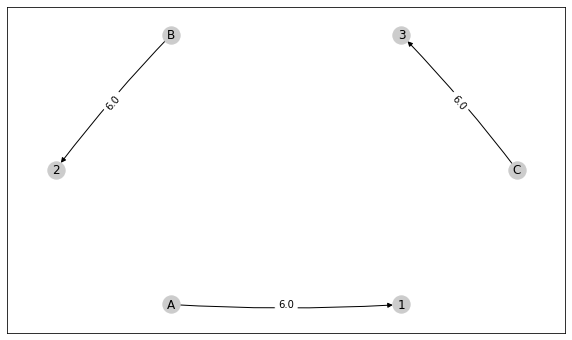



WARNING HERE! OJO AQUI!


These 0 paths were correctly detected (2 undetected):
[]

These 3 paths are spurious:
['6: C3', '6: B2', '6: A1']


In [164]:
# Type 78
T = [
    list(".1A.B2.C3..ABC...A1..2B..3C.123")
]
g, b = evaluate_against(T, ("ABC", "123") )

Claim: all paths (cliques) forming a base are loops. Starting from max(f) -> min(f).

### Examples from previous notebooks

In [ ]:
# combined_loops: lk 12 ABCDE
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ("ABCDE", "lk", "12") )

INFO:Using METHOD_ID 2020-01-25 loop
INFO:Using METHOD_ID 2020-01-25 loop
INFO:Paths inferred (min_clique_size=2: {1.0: [['1', '2'], ['f', 'e']], 2.0: [['e', 'C'], ['e', 'D'], ['2', 'e'], ['1', 'e'], ['e', 'A'], ['e', 'B'], ['f', 'C'], ['f', 'D'], ['2', 'f'], ['1', 'f'], ['f', 'A'], ['f', 'B']], 3.0: [['e', 'f']], 4.0: [['C', 'f'], ['D', 'f'], ['A', 'f'], ['B', 'f'], ['C', 'e'], ['D', 'e'], ['A', 'e'], ['B', 'e']], 6.0: [['A', 'B', 'C', 'D']]})
INFO:Loop candidate FOUND: repeated 2 times in this trace, loop: ['e', 'f']
INFO:Loop candidate FOUND: repeated 3 times in this trace, loop: ['A', 'B', 'C', 'D']
['e', 'f'] ['A', 'B', 'C', 'D'] set()
INFO:My dude ['e', 'f'] is a real loop
['A', 'B', 'C', 'D'] ['e', 'f'] set()
INFO:My dude ['A', 'B', 'C', 'D'] is a real loop
INFO:Removed ['f', 'e']
INFO:Removed ['D', 'C', 'B', 'A']
INFO:Paths inferred (min_clique_size=2: {1.0: [['1', '2']], 2.0: [['2', 'e'], ['2', 'f'], ['1', 'e'], ['1', 'f']], 3.0: [['1', 'C'], ['1', 'D'], ['1', 'A'], ['1', 'B']

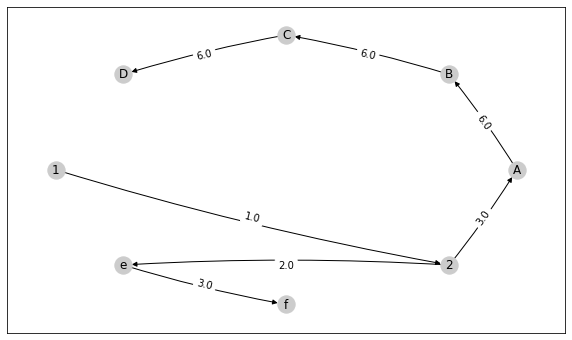

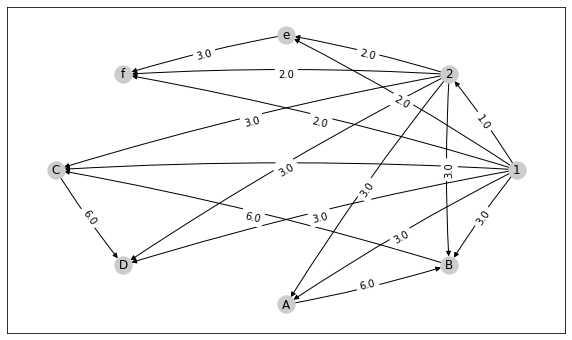

These 3 paths were correctly detected (0 undetected):
['1: 12', '3: ef', '6: ABCD']

These 12 paths are spurious:
['2: 2e', '2: 2f', '2: 1e', '2: 1f', '3: 1C', '3: 1D', '3: 1A', '3: 1B', '3: 2C', '3: 2D', '3: 2A', '3: 2B']


In [119]:
"""
head_with_loop = 12 ABCD* ef*

12 @ABCD @ef
"""
T = [
    list("12ABCDefABCDABCDef"),
]
g, b = evaluate_against(T, ("ABCD", "12", "ef") )

In [ ]:
"""
  @lk - @12 - @ABCDE
"""
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ["ABCDE", "lk", "12"] )

In [ ]:
"""
   ABC * 123        
"""
T = [ list(a) for a in ['ABC123', 'AB1C23', 'AB12C3', 'AB123C', 'A1BC23', 'A1B2C3', 'A1B23C', 
      'A12BC3', 'A12B3C', 'A123BC', '1ABC23', '1AB2C3', '1AB23C', '1A2BC3', 
      '1A2B3C', '1A23BC', '12ABC3', '12AB3C', '12A3BC', '123ABC'
]]
g, b = evaluate_against(T, ("ABC", "123") )

## Still Failing. Still...

In [ ]:
"""
  @def 
       > FG 
  @hjk 
"""        
T = [
    list("defdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("hjk", "def", "FG") )

In [ ]:
"""
          hjk
  12345 <     > FG
          def 
"""
T = [
    list("12345defFG"),
    list("12345hjklFG")
]
g, b = evaluate_against(T, ("12345FG", "hjkl", "def") )

In [ ]:
"""
          @hjk
  12345 <      > FG
          @def 
"""
T = [
    list("12345defdefFG"),
    list("12345hjkhjkFG")
]
g, b = evaluate_against(T, ["12345", "hjk", "def", "FG"] )

In [ ]:
# loop_inside = @hjk | ( (12 | 34) - ABC - @def - FG) )
"""
                     
  @hjk ----------- 
                  \
   12               > FG
       > ABC - @def 
   34 
        
"""
T = [
    list("12ABCdefdefFG"),
    list("12ABCdefdefdefFG"),
    list("34ABCdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("ABC", "34", "12", "hjk", "def", "FG") )

In [ ]:
"""
          @hjk
  12345 <      > FG
          @def 
          @xyz
"""
T = [
    list("12345defdefxyzxyzFG"),
    list("12345xyzxyzhjkhjkFG"),
    list("12345hjkxyzxyzhjkFG"),

]
g, b = evaluate_against(T, ["12345FG", "hjk", "def", "xyz"] )

In [ ]:
tree_trace = [
    list("ABmn12"),
    list("ABmn56"),
    list("ABpq12"),
    list("ABpq56"),
    list("ABst12"),
    list("ABst56"),
]
# inferred_paths = clique_discovery.infer_paths_from_traces( tree_trace )
# untangled_graph( clique_discovery.minimally_connected_graph( inferred_paths ) , with_weigths=False )
g, b = evaluate_against(tree_trace, ["AB", "mn", "12", "pq", "st", "56"] )